In [3]:
import random
import matplotlib.pyplot as plt
import numpy as np
import time
import math
import sys

In [4]:
class CountMinSketch:
    def __init__(self, epsilon, delta):
        """
        :param epsilon: Fator de erro na estimativa de frequência
        :param delta: Probabilidade de erro
        """
        self.epsilon = epsilon
        self.delta = delta
        
        # Calcula a largura e a profundidade com base em epsilon e delta
        self.width = math.ceil(math.e / epsilon)
        self.depth = math.ceil(math.log(1 / delta))
        
        self.table = np.zeros((self.depth, self.width), dtype=int)
        self.hash_functions = [
            lambda x, s=seed: hash((s, x)) % self.width for seed in range(self.depth)
        ]

    def add(self, key):
        for i in range(self.depth):
            self.table[i][self.hash_functions[i](key)] += 1

    def estimate(self, key):
        return min(self.table[i][self.hash_functions[i](key)] for i in range(self.depth))

    def get_error_bound(self, elements):
        """
        Retorna o limite de erro teórico.
        """
        return self.epsilon * elements
    

In [5]:
class BSTNode:
    def __init__(self, key):
        self.key = key
        self.count = 1
        self.left = None
        self.right = None

class BST:
    def __init__(self):
        self.root = None

    def insert(self, key):
        if self.root is None:
            self.root = BSTNode(key)
        else:
            self._insert_recursive(self.root, key)

    def _insert_recursive(self, node, key):
        if key == node.key:
            node.count += 1
        elif key < node.key:
            if node.left is None:
                node.left = BSTNode(key)
            else:
                self._insert_recursive(node.left, key)
        else:  # key > node.key
            if node.right is None:
                node.right = BSTNode(key)
            else:
                self._insert_recursive(node.right, key)

    def query(self, key):
        return self._query_recursive(self.root, key)

    def _query_recursive(self, node, key):
        if node is None:
            return 0
        if key == node.key:
            return node.count
        elif key < node.key:
            return self._query_recursive(node.left, key)
        else:
            return self._query_recursive(node.right, key)


In [6]:
def benchmark(data, cms):
    # Benchmark Insertion Times

    # 1. Count-Min Sketch
    t0 = time.perf_counter()
    for item in data:
        cms.add(item)
    t1 = time.perf_counter()
    cms_insertion_time = t1 - t0

    # 2. Hash Table (Dictionary)
    hash_table = {}
    t0 = time.perf_counter()
    for item in data:
        hash_table[item] = hash_table.get(item, 0) + 1
    t1 = time.perf_counter()
    hash_insertion_time = t1 - t0

    # 3. BST
    bst = BST()
    t0 = time.perf_counter()
    for item in data:
        bst.insert(item)
    t1 = time.perf_counter()
    bst_insertion_time = t1 - t0

    # Benchmark Query Times for 100 random keys
    test_keys = random.sample(list(set(data)), 100)
    cms_results = {}
    hash_results = {}
    bst_results = {}

    t0 = time.perf_counter()
    for key in test_keys:
        cms_results[key] = cms.estimate(key)
    t1 = time.perf_counter()
    cms_query_time = t1 - t0

    t0 = time.perf_counter()
    for key in test_keys:
        hash_results[key] = hash_table.get(key, 0)
    t1 = time.perf_counter()
    hash_query_time = t1 - t0

    t0 = time.perf_counter()
    for key in test_keys:
        bst_results[key] = bst.query(key)
    t1 = time.perf_counter()
    bst_query_time = t1 - t0

    errors = []
    for key in test_keys:
        exact = hash_results[key]
        estimate = cms_results[key]
        errors.append(estimate - exact)
    avg_error = sum(errors) / len(errors)

    # --- Benchmarking Space Usage ---
    cms_memory = cms.table.nbytes + deep_getsizeof(cms.hash_functions)
    hash_memory = deep_getsizeof(hash_table)
    bst_memory = deep_getsizeof(bst)

    return {
        "memory": [cms_memory, hash_memory, bst_memory],
        "error": avg_error,
        "insertion_time": [cms_insertion_time, hash_insertion_time, bst_insertion_time],
        "query_time": [cms_query_time, hash_query_time, bst_query_time]
    }

def deep_getsizeof(obj, seen=None):
    """Recursively compute the memory footprint of an object and its contents."""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    seen.add(obj_id)
    
    if isinstance(obj, dict):
        size += sum(deep_getsizeof(k, seen) for k in obj.keys())
        size += sum(deep_getsizeof(v, seen) for v in obj.values())
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        try:
            size += sum(deep_getsizeof(i, seen) for i in obj)
        except TypeError:
            pass
    elif hasattr(obj, '__dict__'):
        size += deep_getsizeof(obj.__dict__, seen)
    return size

In [7]:
epsilon = 0.00075 # width = 1000
delta = 0.0001 # depth = 10
cms = CountMinSketch(epsilon, delta)

memory_cms = []
memory_hash = []
memory_bst = []

velocidade_cms = []
velocidade_hash = []
velocidade_bst = []

average_error = []
theoric_error = []

entrada = []

init = 4500
while True:
    init = init + 500
    if init >= 50000:
        break

    data = [random.randint(1, init) for _ in range(50000)]
    bm = benchmark(data, cms)

    entrada.append(init)
    memory_cms.append(bm['memory'][0])
    memory_hash.append(bm['memory'][1])
    memory_bst.append(bm['memory'][2])

    velocidade_cms.append(bm['insertion_time'][0])
    velocidade_hash.append(bm['insertion_time'][1])
    velocidade_bst.append(bm['insertion_time'][2])

    average_error.append(bm['error'])
    theoric_error.append(cms.get_error_bound(len(data)))

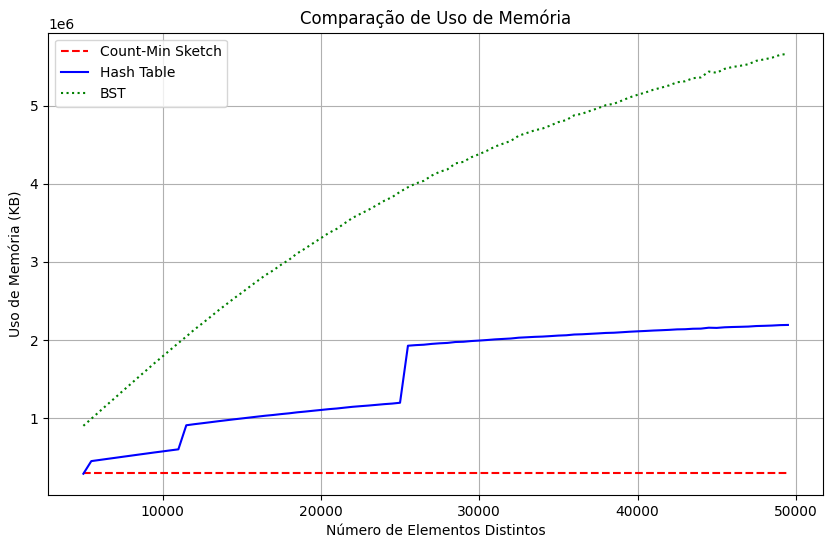

In [8]:
# Memoria
plt.figure(figsize=(10, 6))
plt.plot(entrada, memory_cms, 'r--', label='Count-Min Sketch')
plt.plot(entrada, memory_hash, 'b-', label='Hash Table')
plt.plot(entrada, memory_bst, 'g:', label='BST')

plt.xlabel('Número de Elementos Distintos')
plt.ylabel('Uso de Memória (KB)')
plt.title('Comparação de Uso de Memória')
plt.legend()
plt.grid(True)
plt.show()

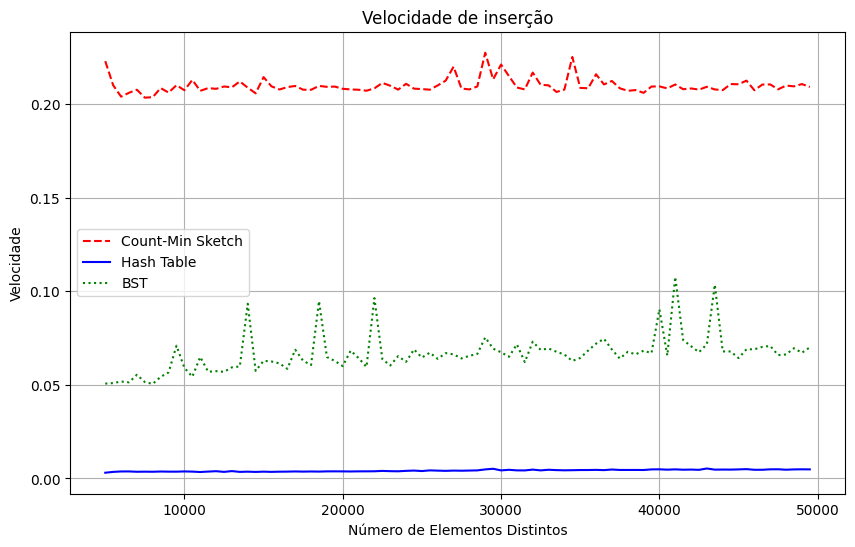

In [9]:
# Velocidade
plt.figure(figsize=(10, 6))
plt.plot(entrada, velocidade_cms, 'r--', label='Count-Min Sketch')
plt.plot(entrada, velocidade_hash, 'b-', label='Hash Table')
plt.plot(entrada, velocidade_bst, 'g:', label='BST')

plt.xlabel('Número de Elementos Distintos')
plt.ylabel('Velocidade')
plt.title('Velocidade de inserção')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\IgorG\AppData\Local\Temp\ipykernel_20428\692761342.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


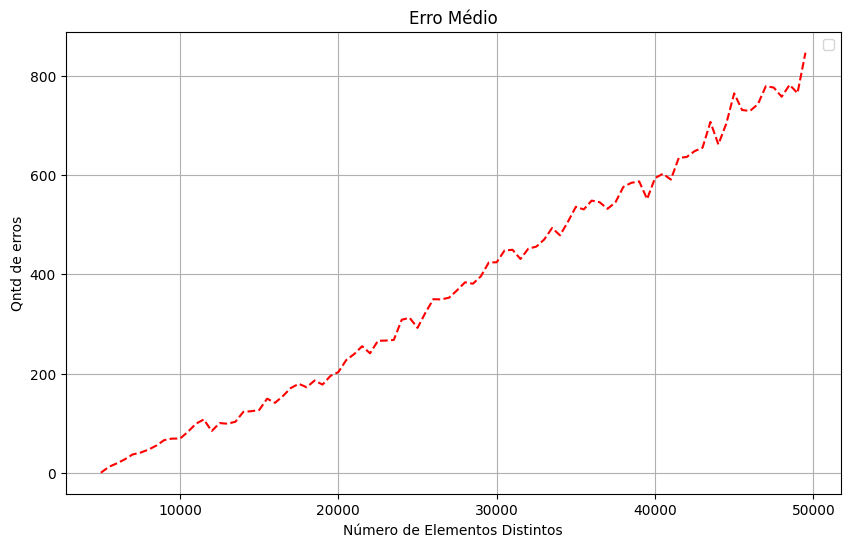

In [10]:
# Erro medio
plt.figure(figsize=(10, 6))
plt.plot(entrada, average_error, 'r--')

plt.xlabel('Número de Elementos Distintos')
plt.ylabel('Qntd de erros')
plt.title('Erro Médio')
plt.legend()
plt.grid(True)
plt.show()

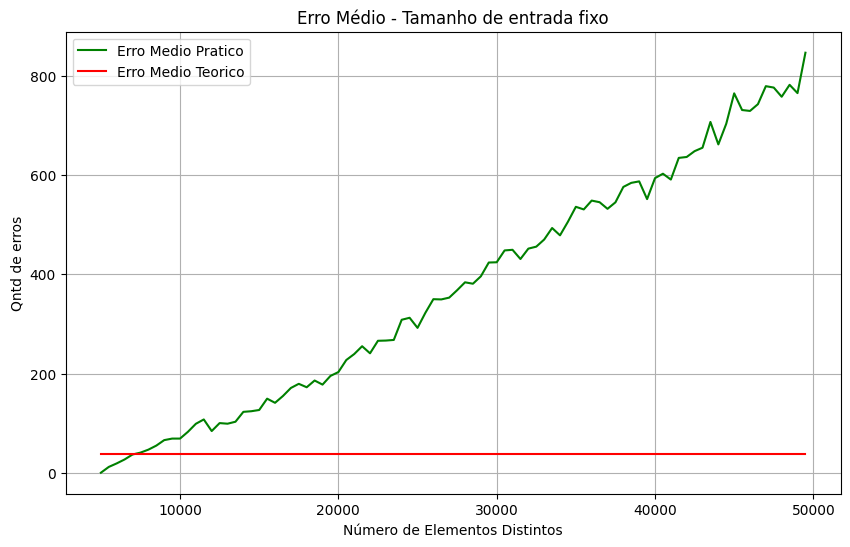

In [11]:
# Erro medio x Erro Teorico (Mesmo tamanho de entrada)
plt.figure(figsize=(10, 6))
plt.plot(entrada, average_error, 'g', label='Erro Medio Pratico')
plt.plot(entrada, theoric_error, 'r', label='Erro Medio Teorico')


plt.xlabel('Número de Elementos Distintos')
plt.ylabel('Qntd de erros')
plt.title('Erro Médio - Tamanho de entrada fixo')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
average_error = []
theoric_error = []

entrada = []

init = 5000
while True:
    init = init + 1000
    if init >= 50000:
        break
    
    entrada.append(init)
    data = [random.randint(1, 5000) for _ in range(init)]
    bm = benchmark(data, cms)

    average_error.append(bm['error'])
    theoric_error.append(cms.get_error_bound(len(data)))

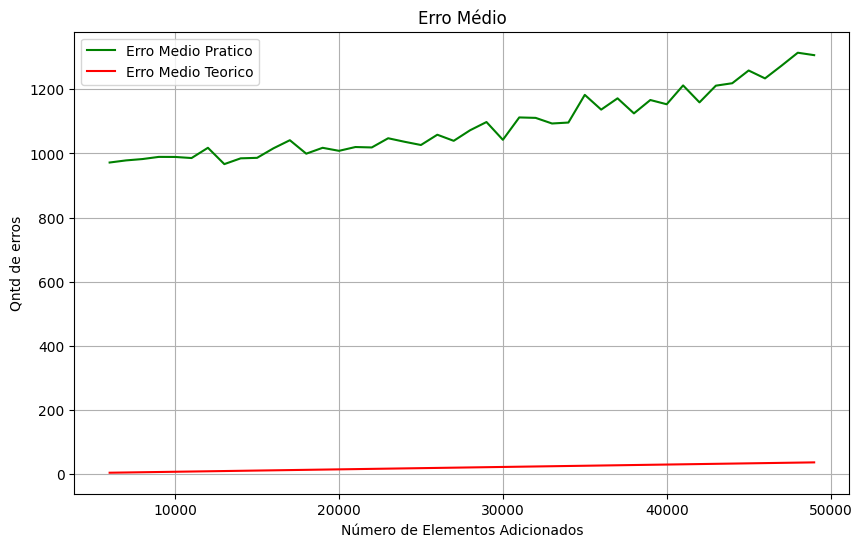

In [13]:
# Erro medio x Erro Teorico
plt.figure(figsize=(10, 6))
plt.plot(entrada, average_error, 'g', label='Erro Medio Pratico')
plt.plot(entrada, theoric_error, 'r', label='Erro Medio Teorico')

plt.xlabel('Número de Elementos Adicionados')
plt.ylabel('Qntd de erros')
plt.title('Erro Médio')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
epsilon = 0.00075

memory_cms = []
average_error = []
theoric_error = []
entrada = []

epsilon = 0.0001
while True:
    epsilon = epsilon + 0.002
    if epsilon >= 0.1:
        break

    cms = CountMinSketch(epsilon, 0.0001)


    data = [random.randint(1, 5000) for _ in range(100000)]
    bm = benchmark(data, cms)

    entrada.append(epsilon)
    memory_cms.append(bm['memory'][0])
    velocidade_cms.append(bm['insertion_time'][0])
    average_error.append(bm['error'])
    theoric_error.append(cms.get_error_bound(len(data)))

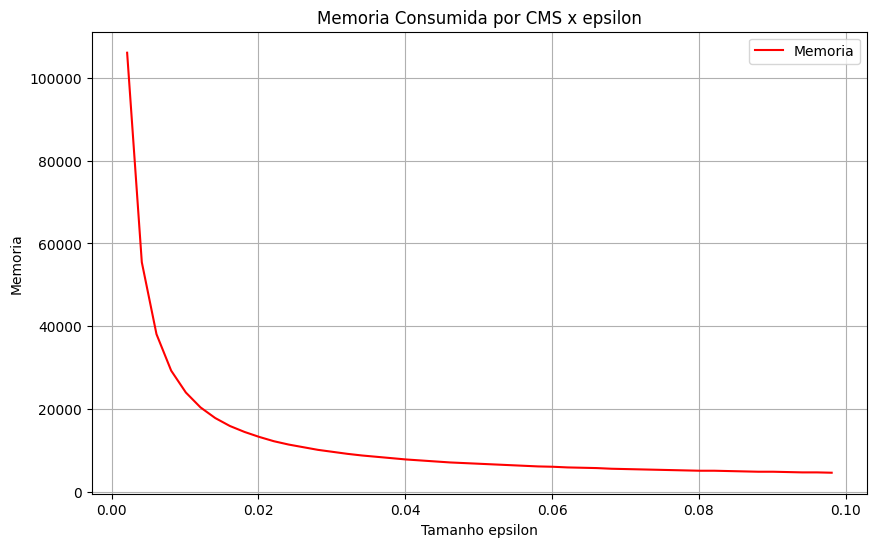

In [15]:
# Erro pratico x epsilon x memoria
plt.figure(figsize=(10, 6))
plt.plot(entrada, memory_cms, 'r', label='Memoria')

plt.xlabel('Tamanho epsilon')
plt.ylabel('Memoria')
plt.title('Memoria Consumida por CMS x epsilon')
plt.legend()
plt.grid(True)
plt.show()